# Tutorial 1: Basic DNA Sequence Analysis

© 2018 Griffin Chure, Soichi Hirokawa and Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)  

--- 


In [33]:
import io # To be able to read strings as files
import string # To extract a list of lowercase letters
import numpy as np
import pandas as pd

# Import Biopython for file I/O.
import Bio.AlignIO
import Bio.Phylo

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting standards
sns.set_context('notebook')
sns.set_style('dark')
%matplotlib inline

# This enables SVG graphics inline 
%config InlineBackend.figure_format = 'svg'

In this tutorial, we'll cover some basics of using Python to read data from a file into memory and how to examine the dispersal patterns of a famous reptile by looking at the sequence of its mitochondrial DNA. 

##  The curious case of *Mabuya atlantica*

Approximately 200 miles off the coast of Brazil exists a small (and quite beautiful) archipelago named [Fernando de Noronha](https://en.wikipedia.org/wiki/Fernando_de_Noronha). The twenty one islands and islets of this archipelago are volcanic in origin and have many endemic plant and animal species. One curious inhabitant of the archipelago is [*Mabuya atlantica*](https://en.wikipedia.org/wiki/Noronha_skink) (also known as the Noronha skink), which is phylogenetically placed along with the African species of *Trachylepis*. Because the archipelago was formed from volcanoes, there was no way that these lizards traveled to the island by land. How did they arrive at the island? In 1888, Alfred Russel Wallace proposed that perhaps the skink arrived on the archipelago by floating on a raft of vegetation across the open ocean, although this trip was estimated to take around 150 days using the knowledge of the oceanic currents from Africa to South America, as is shown in the figure below. 

![](./images/currents.png)

While the exact trajectory of this 'improbable voyage' is still up for debate, the phylogenetic placement of this species is fairly certain. This placement was not performed through morphology but through DNA sequence analysis. In this tutorial, we will use the data from [S. Carranza and E. N. Arnold](http://www.tandfonline.com/doi/abs/10.1017/S1477200003001099?journalCode=tsab20) who sequenced a component of the mitochondrial DNA from a large variety of skinks across the world and from Fernando de Noronha. We will learn how to read in the DNA sequences and score them by the similarity of their sequence to test this hypothesis. 

##  Loading in sequences

Before we can do any sequence comparisons, we must first load the [sequences](http://www.rpgroup.caltech.edu/courses/bi1_2017/data/mabuya_atlantica.zip) from the two text files into our computer to do the analysis. To become familiar with the structure of these documents, let's take a look at them. We can use the shell command `head` to take a look at a small section of the head of the text file. To have access to various shell commands in the Jupyter notebook, we must first type an exclamation point (`!`).

In [2]:
# Look at the sequences from Fernando de Noronha
! head data/mabuya_atlantica/noronha_mabuya.txt

This line should give the following output:

`>Mabuya atlantica isolate 1, Fernando de Noronha
ttgtcttctaaataaagaccagtatgaacggctaaatgaggacaaacctgtctcttttaa
ctaatcagtgaaactgatctcccagtacaaaagctgggatacaaacataagacgagaaga
ccccgtggagcttaaaacaaaaccaccaatcca--c------gccctgg-accctggtgg
actgttttgagttggggcgacttcggaataaaaagaaacttccgagcacagaaccac-aa
attctaaccaaggccaacaagcctaagcata---taa-ctgacccggccc--acgccgat
caacgaaccaagttaccccggggataacagcgctatcttcttcaagagtccctatcaaca
agaaggtttacgacctcgatgttggatcaggacacccaaatggtgcagccgctattaaag
gttcgtttgttcaacgatt`

We can see that the file begins with a carrot '`>`' followed by some information about that specific sample. This is a standard sequence format known as [FASTA format](https://en.wikipedia.org/wiki/FASTA_format). There are [many sequence storage types](https://www.genomatix.de/online_help/help/sequence_formats.html) used in modern sequence analysis and Biopython [is capable of reading many of them](http://biopython.org/wiki/SeqIO). We can also see from the description that the first sample is the first isolate from the island Fernando de Noronha. Below this line is the actual DNA sequence. This sequence is composed of `atgc` and '`-`'. The letters correspond to the base identity at that position while the dash '`-`' indicates an insertion or deletion when the sequences were aligned to each other (see [this wonderful blog post](http://bitesizebio.com/9445/the-beginners-guide-to-dna-sequence-alignment/) for a primer on DNA alignment). Rather than copying and pasting these sequences into our notebooks to actually do the comparison, we'll use the [popular bioinformatics package Biopython](biopython.org) to load in these sequences.

Biopython can be used to do a wide variety of operations on DNA sequences. We will be using it for one rather simple purpose $-$ to load the sequences into memory. To do so, we will need to open the file, tell Biopython to read the contents, and then close the file. We'll first load the sequence from Fernando de Noronha.

In [3]:
# Open the file with sequences from Fernando de Noronha
with open('data/mabuya_atlantica/noronha_mabuya.txt', 'r') as seq:
    noronha_file = Bio.SeqIO.parse(seq, 'fasta')
    noronha_sequences = [record for record in noronha_file]

Let's take a second to cover the syntax line-by-line in the above code cell. 

1. We used a `with` statement to `open` our file for reading only (`'r'`) and assigned it to the variable `seq`.

2. Within the `with` block, we used Biopython's [SeqIO.parse](http://biopython.org/wiki/SeqIO) function to read the file. We specified the format as `'fasta'`. This function generates something called a `SeqRecord` iterator which contains the sequence and description for each entry in the file.

3. We separated each record in the `SeqRecord` iterator into a list by using a single line `for` loop. By putting this loop in brackets `[]`, we convert the output to a list.

Now, each entry in the `noronha_sequences` list has two **attributes**; the sequence (`.seq`) and the description (`.description`). Let's take a look at the sequence and description of the Noronha skink.

In [4]:
# Look at the sequence and description of the first isolate.
noronha_seq = noronha_sequences[0].seq
noronha_desc = noronha_sequences[0].description
print(noronha_seq)
print(noronha_desc)

ttgtcttctaaataaagaccagtatgaacggctaaatgaggacaaacctgtctcttttaactaatcagtgaaactgatctcccagtacaaaagctgggatacaaacataagacgagaagaccccgtggagcttaaaacaaaaccaccaatcca--c------gccctgg-accctggtggactgttttgagttggggcgacttcggaataaaaagaaacttccgagcacagaaccac-aaattctaaccaaggccaacaagcctaagcata---taa-ctgacccggccc--acgccgatcaacgaaccaagttaccccggggataacagcgctatcttcttcaagagtccctatcaacaagaaggtttacgacctcgatgttggatcaggacacccaaatggtgcagccgctattaaaggttcgtttgttcaacgatt
Mabuya atlantica isolate 1, Fernando de Noronha


Let's do this again with the skink sequences from other regions of the world.  

In [5]:
# Open the file with sequences from the rest of the world.
with open('data/mabuya_atlantica/world_mabuya.txt', 'r') as seq:
    world_file = Bio.SeqIO.parse(seq, 'fasta')
    world_sequences = [record for record in world_file]

 Again, let's take a look at the sequence and description.

In [6]:
# Look at the sequence and description of a skink in Brazil
brazil_seq = world_sequences[0].seq
brazil_desc = world_sequences[0].description
print(brazil_seq)
print(brazil_desc)

TTGTCTTTTAAATAAAGACCTGTATGAATGGCTGAATGAGGATAAACCTGTCTCTTATAACTAATCAGTGAAACTGATCTCCCAGTACAAAAGCTGGAATATACACATAAGACGAGAAGACCCTGTGGAGCTTAAAAC-AAACCACTAAACAA-----GT--ATACCACTACCTTAGTGTAC-GTTTTCAGTTGGGGCGACTTCGGAATAAAATGAAACTTCCGAGCACAGAGGCAC-TTCCTCTAACTAAGGCCAACAAGCCAAAGACCC---ATAAACGACCCGGCC---TTGCCGATCAACGAACCAAGTTACCCCAGGGATAACAGCGCAATCTTCTTCGAGAGCCCTTATCAACAAGAAGGTTTACGACCTCGATGTTGGATCAGGACACCCAAATGGTGCAGCCGCTATTAAAGGTTCGTTTGTTCAACGATT
Mabuya agilis, SW Brazil; Mato Grosso do Sul


We see again that we have the DNA sequence (although this one is upper case) and its description (`Mabuya agilis, SW Brazil; Mato Grosso do Sul`). Now that we know how to load and store the sequence information from a file, let's take a look at how to actually perform sequence comparison. 

## Computing a similarity score 

We'll compare the sequences from our skink on Fernando de Noronha to those in other regions of the world. To do so, we'll simplify our analysis to only compare the number of mismatches at a given position in the sequence. This means that we will have to ignore any gaps in the sequence (denoted by '`-`' signifying an insertion or deletion in the reference genome). How do we define what is 'similar'? There are [myriad ways of scoring sequence similarity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3820096/) and is a subject that people have thought very deeply about. To whet our appetite for sequence analysis, we will simply compute what percentage of the base pairs we compared are identical to each other. By this definition, organisms with a larger percent similarity are more similar to each other than those with a lower percent similarity. 

Programmatically, how do we compute this? Remember from the [Python syntax tutorial](t0c_python_syntax_and_plotting.html) we can index letters in a string much like we can numbers in an array or items of a list. To perform the comparison, we'll simply iterate over each position in a sequence and ask two questions:

1. Is this position in either sequence a gap '`-`'? If so, we'll skip it and move to the next position.

2. Is this position in sequence 1 the same in sequence 2? If so, we'll count that as a similarity and move on. Note that by this definition, the two bases must be the **same letter** and in the **same case**. This means we will have to convert our `brazil_seq` to lowercase before we perform the comparison.

Before we begin the loop, we will need to make sure that the two sequences are the same length.

In [7]:
# Determine the length of the two sequences and make sure they are the same.
noronha_length = len(noronha_seq)
brazil_length = len(brazil_seq)
compared_length = (noronha_length == brazil_length)  # Should be True
print('Our sequences are the same length: ' + str(compared_length))

Our sequences are the same length: True


Great! Now, we can go ahead and set up a `for` loop to compare our two example sequences. 

In [8]:
# Convert the Brazil sequence to lowercase.
brazil_seq = brazil_seq.lower()

# Set up a counter to keep track of how many bases are identical.
num_sim = 0

# Set up a counter to keep track of how many positions we've compared.
comp_length = 0

# Iterate through each position in the sequences and compare.
for base in range(brazil_length):
    
    # Make sure we are not comparing a gap.
    if (noronha_seq[base] != '-') and (brazil_seq[base] != '-'):
        
        # Add one position to our counter of the comparison length.
        comp_length += 1   # Note this is same as comp_length = comp_length + 1
       
        # Compare the position and each sequence.
        if noronha_seq[base] == brazil_seq[base]:
            
            # If they are the same, add that to our counter.
            num_sim += 1
            
# Now compute the percent similarity and print it.
score = num_sim / comp_length
print(score)

0.8878281622911695


Our analysis tells us that our sequences are approximately 89% similar. This makes some intuitive sense considering that Fernando de Noronha is only about 200 miles away from the coast of mainland Brazil. However, we have a few other sequences to analyze before we can come to a conclusion regarding their dispersal. Let's take a look at the two other localities (South Africa and Turkey) in our `world_mabuya.txt` file. We could type everything again by hand, but this would be a wonderful opportunity to write a **function**. 

Our function will do the following operations with two provided sequences, `seq_1` and `seq_2`.

1. Ensure that `seq_1` and `seq_2` are the same length. If not, it will produce an error. For this, we'll include a `raise` statement with the `ValueError` exception.

2. Convert both sequences to lowercase and iterate through each sequence and compare every position that is not a gap in either sequence. 

3. Complete and return the percent similarity between the two sequences.


Let's give it a shot. 

In [9]:
def compute_similarity(seq_1, seq_2):
    """
    Computes the percent similarity between two sequences ignoring gaps. 
    
    Parameters
    ----------
    seq_1, seq_2 : strings
        DNA sequences to compare. These must be the same length.
        
    Returns
    -------
    score : float
        The percent similarity between the two sequences. 
    """
    # Make sure they are the same length. 
    if len(seq_1) != len(seq_2):
        raise ValueError('Sequences must be the same length!')
        
    # Make both sequences lowercase.
    seq_1 = seq_1.lower()
    seq_2 = seq_2.lower()
        
    # Set up counters of length and similarity.
    comp_length = 0
    num_sim = 0
    
    # Iterate through each position in the sequences.
    for base in range(len(seq_1)):
        
        # Ensure we are not comparing gaps.
        if (seq_1[base] != '-') and (seq_2[base] != '-'):
            
            # Increase the counter for compared length.
            comp_length += 1
            
            # Compare the two positions.
            if seq_1[base] == seq_2[base]:
                
                # Increase the similarity counter.
                num_sim += 1
                
    # Compute and return the percent similarity.
    score = num_sim  / comp_length
    return score
    

To check our function, let's feed it the two sequences we've worked with for this entire tutorial. It should return a similarity of 0.8878. 

In [10]:
# Test the function on our example sequences
function_score = compute_similarity(noronha_seq, brazil_seq)
print(function_score)

0.8878281622911695


Now, let's check that it fails when we give the function different sequences. 

In [11]:
# Generate sequences of dissimilar length.
seq_1 = 'aTtAcg-a'
seq_2 = 'ttac'

# Run these through the function. This should give an error.
failed_score = compute_similarity(seq_1, seq_2)

ValueError: Sequences must be the same length!

Great! Now that we are confident that our function works as advertised, let's compare the three other localities to Fernando de Noronha. Rather than doing this over three separate times, we can throw it in a `for` loop.

In [12]:
# Loop through the three other localities and print the result to the screen.
for locale in world_sequences:
    
    # Compute the similarity.
    score = compute_similarity(noronha_seq, locale.seq)
    
    # Print the locality and the score.
    print(locale.description, ': Score = ' + str(score))

Mabuya agilis, SW Brazil; Mato Grosso do Sul : Score = 0.8878281622911695
Mabuya capensis, South Africa; Kuga Mts. E. Cape : Score = 0.9304556354916067
Mabuya vittata, Turkey; Osmandere : Score = 0.9049881235154394


It looks like the skink from Brazil is actually the *least* similar of the three locales we examined. These data are suggestive that the skinks of Fernando de Noronha arrived from somewhere on mainland Africa! 

---
# Building a phylogenetic tree.

Given what we have learned so far about the use of molecular phylogenies to gain insight into the relationship between organisms we will now use this part of the tutorial to build a phylogenetic tree given these sequences.

There are several packages to work with phylogenies on Python, the most populars being [`Bio.Phylo`](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-13-209), [`DendroPy`](https://www.dendropy.org) and [`ETE`](http://etetoolkit.org). Each of them with their own advantages and disadvantages. But rather than teaching you how to use these powerful black boxes in this tutorial we will focus in coding our own phylogenetic tree program. Specifically we will implement the [*Neighbor Joining*](https://en.wikipedia.org/wiki/Neighbor_joining#NJ_with_5_taxa) algorithm.

The first thing we need to do is to import a sequence alignment with all 4 species of skinks. The difference between this alignment and the previous ones is that this file contains all 4 species, and the names of the species are only indicated as the country from which the sample was obtained. This will allow us to display the tree more easily.

Let's then use the `Bio.AlignIO` module to read the alignment in which is saved in `fasta` format.

In [42]:
# Read alignment with all species
aln = Bio.AlignIO.read('data/mabuya_atlantica/mabuya_aln.fasta', 'fasta')
# PRint alignment
print(aln)

SingleLetterAlphabet() alignment with 4 rows and 439 columns
ttgtcttctaaataaagaccagtatgaacggctaaatgaggaca...att Fernando_de_Noronha
TTGTCTTTTAAATAAAGACCTGTATGAATGGCTGAATGAGGATA...ATT SW_Brazil
TTGTCTTCTAAATAAAGACCAGTATGAACGGCTAAATGAGGACA...ATT South_Africa
TTGTCTTCTAAATAAAGACCTGTATGAACGGCTAAATGAGGATA...ATT Turkey


The object with which the `TreeConstruction` submodule works is a [`DistanceMatrix`](http://biopython.org/DIST/docs/api/Bio.Phylo.TreeConstruction.DistanceMatrix-class.html) that saves pairwise distances between sequences. The model under which these distances is computed can vary depending on the application. For example for protein alignments the [BLOSUM](https://en.wikipedia.org/wiki/BLOSUM) matrices are a popular method. In our case we can use our `compute_similarity` function to build our own `DistanceMatrix object`.

To first obtain all similarity scores let's use two nested `for` loops to generate a `len(aln)` $\times$ `len(aln)` matrix with similarity scores.

As described in the original [1987 paper](https://watermark.silverchair.com/7sait.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAbAwggGsBgkqhkiG9w0BBwagggGdMIIBmQIBADCCAZIGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM5WHbpNhoFc3bvruMAgEQgIIBY3_ICLdGO26dKo_XZme-TKSrZWW78e1nyGQQdq_NkM8idfte2ObheJCQhIDXRAS6slPlk_PHn5P8f_tknOVbQPcPQqXjNqIqaLOCE3en7iCmCglLvT2OFcXvwkTDR0NsRHVDTcZAEtACIiklk_q7T-GUXiX6xj4lEiMdSL-CZD7H9Cns9mW_WqiJvexKL68l-0aN8aRySSR3Qm1WphVrUUDkfAC1fdNn8rRpI6B6XQep0qrDnRYcNIZILrpH31xEsbKJe9IvOIzaZAvw3gsO45JJ-uptXtPOvnWTLky2jBrI6M_gMsNpeZwhtFwdHTM_f-bpm2uuIAsu5uzLLSwQj4GaZXTAIGVVYXbAlwaXFmuaGzjIfkfsl9deGgsNgEOnCyHbQTWg0i-9tsKfyY6LaGmK9965-CtONZHbiKxNTt9ppVbtyCmGdm6xMRdHr-8Fm3vLnRSYmeR1Gqj50yGs4nkdMGc)
> The principle of this method is to find pairs of operational taxonomic units (OTUs [=neighbors]) that minimize the total branch length at each stage of clustering of OTUs starting with a starlike tree.

The following schematic describes the tree construction process.
![](./images/nj_algorithm.png)

The algorithm starts assuming no hierarchy in the structure of the tree (the starlike tree). Using as an input the pairwise distance between the nodes, the algorithm iteratively finds the two closest nodes and joins them to generate a new parental node (like node $u$ in the second schematic). It repeats this process, updating the distance metric as the number of unused nodes decreases. Once two nodes are joined with one another they cease to exist for the algorithm. It is only via the newly created parental node that these nodes can be connected to the rest of the tree.

---
### Incomplete

In [22]:
# Initialize matrix to save similarity scores
sim_mat = np.zeros([len(aln), len(aln)])

# loop through species in aln
for i, sp1 in enumerate(aln):
    # Extract species 1 sequences
    seq_1 = sp1.seq
    # loop through species in aln
    for j, sp2 in enumerate(aln):
        # Extract species 2 sequences
        seq_2 = sp2.seq
        # Compute and save similarity score
        sim_mat[i, j] = compute_similarity(seq_1, seq_2)
        
print('Similarity matrix for all {:d} sequences:'.format(len(aln)))
print(sim_mat)

Similarity matrix for all 4 sequences:
[[ 1.          0.88782816  0.93045564  0.90498812]
 [ 0.88782816  1.          0.8746988   0.89712919]
 [ 0.93045564  0.8746988   1.          0.89663462]
 [ 0.90498812  0.89712919  0.89663462  1.        ]]


In [23]:
def q_matrix(mat):
    '''
    Computes the Q-Matrix for the Neighbor Joining algorithm
    '''
    # Get the number of entries in matrix
    n = len(mat)
    
    # Initialize matrix to save entries
    q_mat = np.zeros_like(mat)

    # Loop through rows
    for i in range(n):
        for j in range(n):
            q_mat[i, j] = (n - 2) * mat[i, j] - \
                          np.sum(mat[i, :]) - \
                          np.sum(mat[j, :])
    np.fill_diagonal(q_mat, 0)
    
    return q_mat

In [24]:
def neighbor_joining(D, names=None):
    '''
    test
    '''
    # Convert distance matrix to DataFrame to track index identity
    df_D = pd.DataFrame(D)
    
    # Get shape of distance matrix
    shape = D.shape
    
    # Check that the matrix is a square matrix
    if shape[0] != shape[1]:
        raise ValueError('The ditance matrix must be square')
    
    # Check that is is larger than 2 x 2
    if shape[0] == 2:
        raise ValueError('No work to do. The tree has only two nodes')
    
    # Check that the names given are the same length as the distrance matrix
    if names == None:
        names = string.ascii_lowercase[0:len(df_D)]
    elif len(names) != len(D):
        raise ValueError('Are you sure you gave me enough names?')
    
    # Initialize dictionary to save output tree
    tree = dict()
    
    # Initialize dictionary to save node names to generate the newick format
    newick_dict = dict(zip(df_D.index.tolist(), names))
    
    # Start the algorighm
    for loop in range(shape[0] - 2):
        # extract numerical values of DataFrame
        D = df_D.values
        
        # Obtain size of distance matrix
        n = len(D)
        
        # Compute Q-matrix
        q_mat = q_matrix(D)
        
        # Find where the minimum distance is
        row, col = np.where(q_mat == q_mat.min())
        
        # Extract species index (numeric position)
        i, j = row[0], col[0]
        # Extract species index (index name)
        i_idx = df_D.iloc[i,:].name
        j_idx = df_D.iloc[j,:].name
        
        # Compute distance ∆
        delta_dist = np.sum(D[i, :] - D[j, :]) / (n - 2)
        
        # Compute distance of the recently joined edges
        limb_length_i = (1 / 2) * (D[i, j] + delta_dist)
        limb_length_j = (1 / 2) * (D[i, j] - delta_dist)
        
        # Generate expanded matrix with extra row to update distances
        mat_plus = np.zeros(np.array(D.shape) + 1)
        # Replace 0's with known distance
        mat_plus[0:D.shape[0], 0:D.shape[1]] = D
        
        # Update distance to new node
        for k in range(len(D)):
            mat_plus[k, -1] = (1 / 2) * (D[k, i] + D[k, j] - D[i, j])
            mat_plus[-1, k] = mat_plus[k, -1]
            
        # Define new node index
        m = max(df_D.index.tolist()) + 1
        # Extract index from current DataFrame
        new_idx = df_D.index.tolist() + [m]
        # Convert extended distance matrix to data frame using same index
        df_D = pd.DataFrame(mat_plus, index=new_idx, columns=new_idx)
        # Drop the rows and columns of the two nodes that were joined
        df_D.drop(index=[i_idx, j_idx], inplace=True)
        df_D.drop(columns=[i_idx, j_idx], inplace=True)
        
        # Add entry to tree
        tree[str(i_idx) + '->' + str(m)] = limb_length_i
        tree[str(j_idx) + '->' + str(m)] = limb_length_j
        
        tree[str(m) + '->' + str(i_idx)] = limb_length_i
        tree[str(m) + '->' + str(j_idx)] = limb_length_j
        
        # Newick format of this joined nodes
        name = '({0:s}:{2:0.2f}, {1:s}:{3:0.2f})'.\
               format(newick_dict[i_idx], newick_dict[j_idx],
                      limb_length_i, limb_length_j)
        # Append name to newick_dict
        newick_dict[m] = name
        
    # Extract last two knobs to be joined
    last_idx = df_D.index.tolist()
    # Extract last distance
    last_dist = df_D.iloc[1, 0]
    
    # Append the distance of the last two-knobs left
    tree[str(last_idx[0]) + '->' + str(last_idx[1])] = last_dist
    tree[str(last_idx[1]) + '->' + str(last_idx[0])] = last_dist
    
    newick_str = '({0:s}:{2:0.2f}, {1:s}:{3:0.2f})'.\
               format(newick_dict[last_idx[0]], newick_dict[last_idx[1]],
                      last_dist, last_dist)
    
    return tree, newick_str

In [36]:
D = np.array([[0, 23, 27, 20],
              [23, 0, 30, 28],
              [27, 30, 0, 30],
              [20, 28, 30, 0]])
tree_dict, newick = neighbor_joining(D)
tree_dict

{'0->4': 8.0,
 '1->5': 13.5,
 '2->5': 16.5,
 '3->4': 12.0,
 '4->0': 8.0,
 '4->3': 12.0,
 '4->5': 2.0,
 '5->1': 13.5,
 '5->2': 16.5,
 '5->4': 2.0}

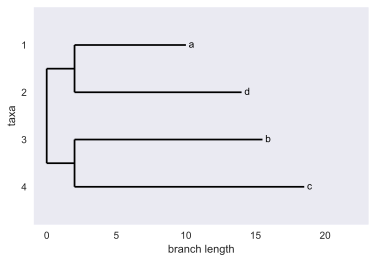

In [37]:
tree = Bio.Phylo.read(io.StringIO(newick), 'newick')
Bio.Phylo.draw(tree)

In [38]:
D = np.array([[0, 5, 9, 9, 8],
              [5, 0, 10, 10, 9],
              [9, 10, 0, 8, 7],
              [9, 10, 8, 0, 3],
              [8, 9, 7, 3, 0]])
tree_dict, newick = neighbor_joining(D)

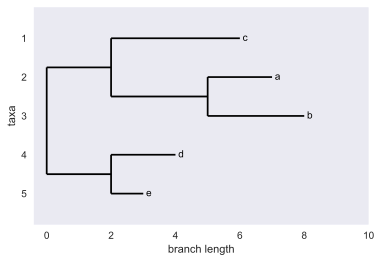

In [39]:
tree = Bio.Phylo.read(io.StringIO(newick), 'newick')
Bio.Phylo.draw(tree)

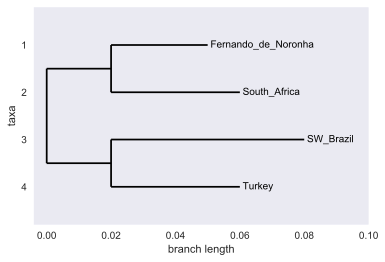

In [40]:
species_names = [record.name for record in aln]
tree_dict, tree_newick = neighbor_joining(1 - sim_mat, names=species_names)
newick = Bio.Phylo.read(io.StringIO(tree_newick), 'newick')
Bio.Phylo.draw(newick)